In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/pytorch-gnn-meta-attack
%ls

/content/drive/MyDrive/Colab Notebooks/pytorch-gnn-meta-attack
data/   metattack.py   __pycache__/  results/           Untitled0.ipynb
gcn.py  pre-attacked/  README.md     test_metattack.py  utils.py


In [5]:
#!pip install torch_geometric

In [6]:
import torch
from utils import *
import argparse
import numpy as np
from metattack import MetaApprox, Metattack
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
from matplotlib import pyplot as plt
from torch_geometric.utils import dense_to_sparse
from torch_geometric.nn.models import GAT

In [7]:
import sys
import argparse

sys.argv = [
    'notebook',  # Placeholder for the script name (usually argv[0])
    '--seed', '15',
    '--epochs', '200',
    '--lr', '0.01',
    '--hidden', '16',
    '--dataset', 'citeseer',
    '--ptb_rate', '0.05',
    '--model', 'Meta-Self'
]

# Now use argparse as usual
parser = argparse.ArgumentParser()
parser.add_argument('--seed', type=int, default=15, help='Random seed.')
parser.add_argument('--epochs', type=int, default=200, help='Number of epochs to train.')
parser.add_argument('--lr', type=float, default=0.01, help='Initial learning rate.')
parser.add_argument('--hidden', type=int, default=8, help='Number of hidden units.')
parser.add_argument('--dataset', type=str, default='citeseer', choices=['cora', 'cora_ml', 'citeseer', 'polblogs'], help='dataset')
parser.add_argument('--ptb_rate', type=float, default=0.05, help='perturbation rate')
parser.add_argument('--model', type=str, default='Meta-Self', choices=['A-Meta-Self', 'Meta-Self'], help='model variant')

args = parser.parse_args()

# Now you can access args as if you had passed them from the command line
print(args)

Namespace(seed=15, epochs=200, lr=0.01, hidden=16, dataset='citeseer', ptb_rate=0.05, model='Meta-Self')


In [77]:

cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

np.random.seed(args.seed)
torch.manual_seed(args.seed)
if device != 'cpu':
    torch.cuda.manual_seed(args.seed)

# === loading dataset
adj, features, labels = load_data(dataset=args.dataset)
nclass = max(labels) + 1

val_size = 0.1
test_size = 0.8
train_size = 1 - test_size - val_size

idx = np.arange(adj.shape[0])
idx_train, idx_val, idx_test = get_train_val_test(idx, train_size, val_size, test_size, stratify=labels)
idx_unlabeled = np.union1d(idx_val, idx_test)
perturbations = int(args.ptb_rate * (adj.sum()//2))

adj, features, labels = preprocess(adj, features, labels, preprocess_adj=False)

# set up attack model
if 'Self' in args.model:
    lambda_ = 0
if 'Train' in args.model:
    lambda_ = 1
if 'Both' in args.model:
    lambda_ = 0.5

if 'A' in args.model:
    model = MetaApprox(nfeat=features.shape[1], hidden_sizes=[args.hidden],
                       nnodes=adj.shape[0], nclass=nclass, dropout=0.5,
                       train_iters=100, attack_features=False, lambda_=lambda_, device=device)

else:
    model = Metattack(nfeat=features.shape[1], hidden_sizes=[args.hidden],
                       nnodes=adj.shape[0], nclass=nclass, dropout=0.5,
                       train_iters=100, attack_features=False, lambda_=lambda_, device=device)

if device != 'cpu':
    adj = adj.to(device)
    features = features.to(device)
    labels = labels.to(device)
    model = model.to(device)


Loading citeseer dataset...
reading citeseer...
Selecting 1 largest connected components


In [80]:
def test(edge_index):
    ''' Test on GAT using edge_index format '''
    gatv1 = GAT(
        in_channels=features.shape[1],
        num_layers=8,
        hidden_channels=args.hidden,
        out_channels=labels.max().item() + 1,
        dropout=0.5,
        heads=8
    ).to(device)

    optimizer = optim.Adam(gatv1.parameters(), lr=args.lr, weight_decay=5e-4)

    gatv1.train()

    for epoch in range(args.epochs):
        optimizer.zero_grad()
        output = gatv1(features, edge_index)  # Pass edge_index instead of adj
        output = F.log_softmax(output, dim=1)  # Ensure log softmax is applied

        loss_train = F.nll_loss(output[idx_train], labels[idx_train])
        acc_train = accuracy(output[idx_train], labels[idx_train])
        loss_train.backward()
        torch.nn.utils.clip_grad_norm_(gatv1.parameters(), max_norm=1.0)
        optimizer.step()

    gatv1.eval()
    output = gatv1(features, edge_index)

    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    print("Test set results:",
           "loss= {:.4f}".format(loss_test.item()),
           "accuracy= {:.4f}".format(acc_test.item()))

    return acc_test.item()


In [10]:

modified_adj = model(features, adj, labels, idx_train, idx_unlabeled, perturbations, ll_constraint=False)
modified_adj = modified_adj.detach()

=== training surrogate model to predict unlabled data for self-training


Perturbing graph:   1%|          | 1/183 [00:01<03:42,  1.22s/it]

GCN loss on unlabled data: 1.1313300132751465
GCN acc on unlabled data: 0.7298578199052133
attack loss: 0.31128424406051636


Perturbing graph:   1%|          | 2/183 [00:02<02:59,  1.01it/s]

GCN loss on unlabled data: 1.1109369993209839
GCN acc on unlabled data: 0.7288046340179041
attack loss: 0.31076034903526306


Perturbing graph:   2%|▏         | 3/183 [00:02<02:46,  1.08it/s]

GCN loss on unlabled data: 1.1562613248825073
GCN acc on unlabled data: 0.7187993680884676
attack loss: 0.30738481879234314


Perturbing graph:   2%|▏         | 4/183 [00:03<02:40,  1.12it/s]

GCN loss on unlabled data: 1.1377426385879517
GCN acc on unlabled data: 0.7298578199052133
attack loss: 0.35455694794654846


Perturbing graph:   3%|▎         | 5/183 [00:04<02:35,  1.14it/s]

GCN loss on unlabled data: 1.221013069152832
GCN acc on unlabled data: 0.7103738809899947
attack loss: 0.3732700049877167


Perturbing graph:   3%|▎         | 6/183 [00:05<02:33,  1.15it/s]

GCN loss on unlabled data: 1.1276741027832031
GCN acc on unlabled data: 0.7235387045813585
attack loss: 0.3622691035270691


Perturbing graph:   4%|▍         | 7/183 [00:06<02:31,  1.16it/s]

GCN loss on unlabled data: 1.180314540863037
GCN acc on unlabled data: 0.7177461822011585
attack loss: 0.38775646686553955


Perturbing graph:   4%|▍         | 8/183 [00:07<02:29,  1.17it/s]

GCN loss on unlabled data: 1.1817110776901245
GCN acc on unlabled data: 0.7203791469194312
attack loss: 0.3945624530315399


Perturbing graph:   5%|▍         | 9/183 [00:07<02:28,  1.17it/s]

GCN loss on unlabled data: 1.135021686553955
GCN acc on unlabled data: 0.7214323328067404
attack loss: 0.3639844059944153


Perturbing graph:   5%|▌         | 10/183 [00:08<02:30,  1.15it/s]

GCN loss on unlabled data: 1.1710256338119507
GCN acc on unlabled data: 0.7166929963138493
attack loss: 0.38687044382095337


Perturbing graph:   6%|▌         | 11/183 [00:09<02:28,  1.16it/s]

GCN loss on unlabled data: 1.185160517692566
GCN acc on unlabled data: 0.7193259610321221
attack loss: 0.39486128091812134


Perturbing graph:   7%|▋         | 12/183 [00:10<02:26,  1.16it/s]

GCN loss on unlabled data: 1.1739745140075684
GCN acc on unlabled data: 0.7203791469194312
attack loss: 0.38729798793792725


Perturbing graph:   7%|▋         | 13/183 [00:11<02:25,  1.17it/s]

GCN loss on unlabled data: 1.1349873542785645
GCN acc on unlabled data: 0.7240652975250131
attack loss: 0.4308728873729706


Perturbing graph:   8%|▊         | 14/183 [00:12<02:24,  1.17it/s]

GCN loss on unlabled data: 1.1946275234222412
GCN acc on unlabled data: 0.7140600315955765
attack loss: 0.4388206899166107


Perturbing graph:   8%|▊         | 15/183 [00:13<02:23,  1.17it/s]

GCN loss on unlabled data: 1.1685813665390015
GCN acc on unlabled data: 0.708794102159031
attack loss: 0.4112633168697357


Perturbing graph:   9%|▊         | 16/183 [00:14<02:23,  1.17it/s]

GCN loss on unlabled data: 1.1756417751312256
GCN acc on unlabled data: 0.7203791469194312
attack loss: 0.418959379196167


Perturbing graph:   9%|▉         | 17/183 [00:14<02:22,  1.17it/s]

GCN loss on unlabled data: 1.1617844104766846
GCN acc on unlabled data: 0.7219589257503949
attack loss: 0.45234227180480957


Perturbing graph:  10%|▉         | 18/183 [00:15<02:21,  1.17it/s]

GCN loss on unlabled data: 1.1749118566513062
GCN acc on unlabled data: 0.7172195892575038
attack loss: 0.45962491631507874


Perturbing graph:  10%|█         | 19/183 [00:16<02:20,  1.17it/s]

GCN loss on unlabled data: 1.1634918451309204
GCN acc on unlabled data: 0.7151132174828857
attack loss: 0.5025478005409241


Perturbing graph:  11%|█         | 20/183 [00:17<02:19,  1.17it/s]

GCN loss on unlabled data: 1.1649043560028076
GCN acc on unlabled data: 0.7161664033701948
attack loss: 0.42443811893463135


Perturbing graph:  11%|█▏        | 21/183 [00:18<02:18,  1.17it/s]

GCN loss on unlabled data: 1.161899447441101
GCN acc on unlabled data: 0.7193259610321221
attack loss: 0.43108391761779785


Perturbing graph:  12%|█▏        | 22/183 [00:19<02:17,  1.17it/s]

GCN loss on unlabled data: 1.237790822982788
GCN acc on unlabled data: 0.7177461822011585
attack loss: 0.4751286506652832


Perturbing graph:  13%|█▎        | 23/183 [00:20<02:17,  1.17it/s]

GCN loss on unlabled data: 1.1581820249557495
GCN acc on unlabled data: 0.718272775144813
attack loss: 0.44974640011787415


Perturbing graph:  13%|█▎        | 24/183 [00:20<02:16,  1.17it/s]

GCN loss on unlabled data: 1.188507080078125
GCN acc on unlabled data: 0.7224855186940494
attack loss: 0.48319849371910095


Perturbing graph:  14%|█▎        | 25/183 [00:21<02:15,  1.17it/s]

GCN loss on unlabled data: 1.1271347999572754
GCN acc on unlabled data: 0.7214323328067404
attack loss: 0.479107141494751


Perturbing graph:  14%|█▍        | 26/183 [00:22<02:14,  1.16it/s]

GCN loss on unlabled data: 1.198291301727295
GCN acc on unlabled data: 0.718272775144813
attack loss: 0.49719518423080444


Perturbing graph:  15%|█▍        | 27/183 [00:23<02:14,  1.16it/s]

GCN loss on unlabled data: 1.1572271585464478
GCN acc on unlabled data: 0.7251184834123222
attack loss: 0.5206416845321655


Perturbing graph:  15%|█▌        | 28/183 [00:24<02:13,  1.16it/s]

GCN loss on unlabled data: 1.1937540769577026
GCN acc on unlabled data: 0.7140600315955765
attack loss: 0.4889051616191864


Perturbing graph:  16%|█▌        | 29/183 [00:25<02:12,  1.16it/s]

GCN loss on unlabled data: 1.1977742910385132
GCN acc on unlabled data: 0.7145866245392312
attack loss: 0.503330647945404


Perturbing graph:  16%|█▋        | 30/183 [00:26<02:12,  1.16it/s]

GCN loss on unlabled data: 1.1761947870254517
GCN acc on unlabled data: 0.7140600315955765
attack loss: 0.48376500606536865


Perturbing graph:  17%|█▋        | 31/183 [00:26<02:11,  1.16it/s]

GCN loss on unlabled data: 1.2256193161010742
GCN acc on unlabled data: 0.7066877303844128
attack loss: 0.5365046262741089


Perturbing graph:  17%|█▋        | 32/183 [00:27<02:10,  1.16it/s]

GCN loss on unlabled data: 1.231107473373413
GCN acc on unlabled data: 0.7161664033701948
attack loss: 0.5073526501655579


Perturbing graph:  18%|█▊        | 33/183 [00:28<02:09,  1.16it/s]

GCN loss on unlabled data: 1.2059521675109863
GCN acc on unlabled data: 0.7203791469194312
attack loss: 0.49082767963409424


Perturbing graph:  19%|█▊        | 34/183 [00:29<02:08,  1.16it/s]

GCN loss on unlabled data: 1.165286898612976
GCN acc on unlabled data: 0.7177461822011585
attack loss: 0.5127403736114502


Perturbing graph:  19%|█▉        | 35/183 [00:30<02:08,  1.15it/s]

GCN loss on unlabled data: 1.1667108535766602
GCN acc on unlabled data: 0.713533438651922
attack loss: 0.5544131994247437


Perturbing graph:  20%|█▉        | 36/183 [00:31<02:07,  1.15it/s]

GCN loss on unlabled data: 1.2269423007965088
GCN acc on unlabled data: 0.713533438651922
attack loss: 0.5228855609893799


Perturbing graph:  20%|██        | 37/183 [00:32<02:07,  1.15it/s]

GCN loss on unlabled data: 1.1865496635437012
GCN acc on unlabled data: 0.713533438651922
attack loss: 0.5208845138549805


Perturbing graph:  21%|██        | 38/183 [00:32<02:06,  1.15it/s]

GCN loss on unlabled data: 1.2266266345977783
GCN acc on unlabled data: 0.7151132174828857
attack loss: 0.5581024885177612


Perturbing graph:  21%|██▏       | 39/183 [00:33<02:05,  1.15it/s]

GCN loss on unlabled data: 1.1836161613464355
GCN acc on unlabled data: 0.7103738809899947
attack loss: 0.5473315119743347


Perturbing graph:  22%|██▏       | 40/183 [00:34<02:04,  1.15it/s]

GCN loss on unlabled data: 1.2015035152435303
GCN acc on unlabled data: 0.7124802527646129
attack loss: 0.5666105151176453


Perturbing graph:  22%|██▏       | 41/183 [00:35<02:03,  1.15it/s]

GCN loss on unlabled data: 1.1927106380462646
GCN acc on unlabled data: 0.7161664033701948
attack loss: 0.5571102499961853


Perturbing graph:  23%|██▎       | 42/183 [00:36<02:03,  1.15it/s]

GCN loss on unlabled data: 1.2639620304107666
GCN acc on unlabled data: 0.6998420221169036
attack loss: 0.5896412134170532


Perturbing graph:  23%|██▎       | 43/183 [00:37<02:02,  1.14it/s]

GCN loss on unlabled data: 1.2026902437210083
GCN acc on unlabled data: 0.708794102159031
attack loss: 0.5694659948348999


Perturbing graph:  24%|██▍       | 44/183 [00:38<02:01,  1.14it/s]

GCN loss on unlabled data: 1.236229658126831
GCN acc on unlabled data: 0.7082675092153764
attack loss: 0.5820689797401428


Perturbing graph:  25%|██▍       | 45/183 [00:39<02:00,  1.14it/s]

GCN loss on unlabled data: 1.2090892791748047
GCN acc on unlabled data: 0.7124802527646129
attack loss: 0.5775654911994934


Perturbing graph:  25%|██▌       | 46/183 [00:39<01:59,  1.14it/s]

GCN loss on unlabled data: 1.2774566411972046
GCN acc on unlabled data: 0.7035281727224855
attack loss: 0.6369810700416565


Perturbing graph:  26%|██▌       | 47/183 [00:40<01:59,  1.14it/s]

GCN loss on unlabled data: 1.1947376728057861
GCN acc on unlabled data: 0.7035281727224855
attack loss: 0.6034984588623047


Perturbing graph:  26%|██▌       | 48/183 [00:41<01:58,  1.14it/s]

GCN loss on unlabled data: 1.206920862197876
GCN acc on unlabled data: 0.7072143233280673
attack loss: 0.5920578837394714


Perturbing graph:  27%|██▋       | 49/183 [00:42<01:57,  1.14it/s]

GCN loss on unlabled data: 1.2162846326828003
GCN acc on unlabled data: 0.7109004739336492
attack loss: 0.6099023222923279


Perturbing graph:  27%|██▋       | 50/183 [00:43<01:56,  1.14it/s]

GCN loss on unlabled data: 1.2159379720687866
GCN acc on unlabled data: 0.7066877303844128
attack loss: 0.599165678024292


Perturbing graph:  28%|██▊       | 51/183 [00:44<01:55,  1.14it/s]

GCN loss on unlabled data: 1.2219514846801758
GCN acc on unlabled data: 0.70405476566614
attack loss: 0.6268233060836792


Perturbing graph:  28%|██▊       | 52/183 [00:45<01:54,  1.14it/s]

GCN loss on unlabled data: 1.180090308189392
GCN acc on unlabled data: 0.7072143233280673
attack loss: 0.6120113730430603


Perturbing graph:  29%|██▉       | 53/183 [00:46<01:54,  1.14it/s]

GCN loss on unlabled data: 1.218353033065796
GCN acc on unlabled data: 0.7151132174828857
attack loss: 0.5824301838874817


Perturbing graph:  30%|██▉       | 54/183 [00:47<01:53,  1.14it/s]

GCN loss on unlabled data: 1.2158687114715576
GCN acc on unlabled data: 0.6987888362295944
attack loss: 0.572052001953125


Perturbing graph:  30%|███       | 55/183 [00:47<01:52,  1.14it/s]

GCN loss on unlabled data: 1.2400777339935303
GCN acc on unlabled data: 0.7024749868351764
attack loss: 0.6239878535270691


Perturbing graph:  31%|███       | 56/183 [00:48<01:51,  1.14it/s]

GCN loss on unlabled data: 1.2080028057098389
GCN acc on unlabled data: 0.6998420221169036
attack loss: 0.6319745779037476


Perturbing graph:  31%|███       | 57/183 [00:49<01:50,  1.14it/s]

GCN loss on unlabled data: 1.304200291633606
GCN acc on unlabled data: 0.6998420221169036
attack loss: 0.6822695136070251


Perturbing graph:  32%|███▏      | 58/183 [00:50<01:49,  1.14it/s]

GCN loss on unlabled data: 1.260185718536377
GCN acc on unlabled data: 0.6919431279620852
attack loss: 0.6348859071731567


Perturbing graph:  32%|███▏      | 59/183 [00:51<01:49,  1.13it/s]

GCN loss on unlabled data: 1.2470263242721558
GCN acc on unlabled data: 0.7035281727224855
attack loss: 0.6098705530166626


Perturbing graph:  33%|███▎      | 60/183 [00:52<01:48,  1.13it/s]

GCN loss on unlabled data: 1.2768772840499878
GCN acc on unlabled data: 0.6987888362295944
attack loss: 0.6651214361190796


Perturbing graph:  33%|███▎      | 61/183 [00:53<01:47,  1.13it/s]

GCN loss on unlabled data: 1.2333613634109497
GCN acc on unlabled data: 0.6940494997367035
attack loss: 0.6517236828804016


Perturbing graph:  34%|███▍      | 62/183 [00:54<01:47,  1.13it/s]

GCN loss on unlabled data: 1.2848948240280151
GCN acc on unlabled data: 0.7030015797788309
attack loss: 0.674740195274353


Perturbing graph:  34%|███▍      | 63/183 [00:54<01:46,  1.13it/s]

GCN loss on unlabled data: 1.3089720010757446
GCN acc on unlabled data: 0.7014218009478672
attack loss: 0.6784056425094604


Perturbing graph:  35%|███▍      | 64/183 [00:55<01:45,  1.13it/s]

GCN loss on unlabled data: 1.2841922044754028
GCN acc on unlabled data: 0.7024749868351764
attack loss: 0.6293249726295471


Perturbing graph:  36%|███▌      | 65/183 [00:56<01:44,  1.13it/s]

GCN loss on unlabled data: 1.2150626182556152
GCN acc on unlabled data: 0.7003686150605581
attack loss: 0.6700941324234009


Perturbing graph:  36%|███▌      | 66/183 [00:57<01:43,  1.13it/s]

GCN loss on unlabled data: 1.2652472257614136
GCN acc on unlabled data: 0.6956292785676671
attack loss: 0.7452191114425659


Perturbing graph:  37%|███▋      | 67/183 [00:58<01:43,  1.12it/s]

GCN loss on unlabled data: 1.2996306419372559
GCN acc on unlabled data: 0.6966824644549763
attack loss: 0.7485244274139404


Perturbing graph:  37%|███▋      | 68/183 [00:59<01:42,  1.12it/s]

GCN loss on unlabled data: 1.264354944229126
GCN acc on unlabled data: 0.6861506055818851
attack loss: 0.6200634837150574


Perturbing graph:  38%|███▊      | 69/183 [01:00<01:41,  1.12it/s]

GCN loss on unlabled data: 1.276710033416748
GCN acc on unlabled data: 0.6956292785676671
attack loss: 0.7009890079498291


Perturbing graph:  38%|███▊      | 70/183 [01:01<01:40,  1.12it/s]

GCN loss on unlabled data: 1.2695618867874146
GCN acc on unlabled data: 0.7003686150605581
attack loss: 0.7339214086532593


Perturbing graph:  39%|███▉      | 71/183 [01:02<01:40,  1.12it/s]

GCN loss on unlabled data: 1.2625199556350708
GCN acc on unlabled data: 0.7014218009478672
attack loss: 0.729687511920929


Perturbing graph:  39%|███▉      | 72/183 [01:03<01:39,  1.11it/s]

GCN loss on unlabled data: 1.378983974456787
GCN acc on unlabled data: 0.6856240126382306
attack loss: 0.7773731350898743


Perturbing graph:  40%|███▉      | 73/183 [01:03<01:38,  1.11it/s]

GCN loss on unlabled data: 1.32955002784729
GCN acc on unlabled data: 0.689836756187467
attack loss: 0.7248912453651428


Perturbing graph:  40%|████      | 74/183 [01:04<01:38,  1.11it/s]

GCN loss on unlabled data: 1.3098344802856445
GCN acc on unlabled data: 0.6977356503422854
attack loss: 0.717818558216095


Perturbing graph:  41%|████      | 75/183 [01:05<01:37,  1.11it/s]

GCN loss on unlabled data: 1.3640782833099365
GCN acc on unlabled data: 0.6882569773565034
attack loss: 0.827308714389801


Perturbing graph:  42%|████▏     | 76/183 [01:06<01:36,  1.11it/s]

GCN loss on unlabled data: 1.336966633796692
GCN acc on unlabled data: 0.7019483938915217
attack loss: 0.8019043803215027


Perturbing graph:  42%|████▏     | 77/183 [01:07<01:35,  1.11it/s]

GCN loss on unlabled data: 1.3338474035263062
GCN acc on unlabled data: 0.6924697209057398
attack loss: 0.7776044607162476


Perturbing graph:  43%|████▎     | 78/183 [01:08<01:35,  1.10it/s]

GCN loss on unlabled data: 1.349756121635437
GCN acc on unlabled data: 0.6951026856240126
attack loss: 0.7745321393013


Perturbing graph:  43%|████▎     | 79/183 [01:09<01:34,  1.10it/s]

GCN loss on unlabled data: 1.3137199878692627
GCN acc on unlabled data: 0.6903633491311216
attack loss: 0.765467643737793


Perturbing graph:  44%|████▎     | 80/183 [01:10<01:33,  1.10it/s]

GCN loss on unlabled data: 1.3023428916931152
GCN acc on unlabled data: 0.6882569773565034
attack loss: 0.7411221861839294


Perturbing graph:  44%|████▍     | 81/183 [01:11<01:32,  1.10it/s]

GCN loss on unlabled data: 1.3201777935028076
GCN acc on unlabled data: 0.6866771985255397
attack loss: 0.7734050154685974


Perturbing graph:  45%|████▍     | 82/183 [01:12<01:31,  1.10it/s]

GCN loss on unlabled data: 1.2915011644363403
GCN acc on unlabled data: 0.6956292785676671
attack loss: 0.7821069955825806


Perturbing graph:  45%|████▌     | 83/183 [01:13<01:30,  1.10it/s]

GCN loss on unlabled data: 1.3564932346343994
GCN acc on unlabled data: 0.6835176408636123
attack loss: 0.832784116268158


Perturbing graph:  46%|████▌     | 84/183 [01:13<01:30,  1.10it/s]

GCN loss on unlabled data: 1.353482961654663
GCN acc on unlabled data: 0.693522906793049
attack loss: 0.7806888818740845


Perturbing graph:  46%|████▋     | 85/183 [01:14<01:29,  1.10it/s]

GCN loss on unlabled data: 1.3884260654449463
GCN acc on unlabled data: 0.6951026856240126
attack loss: 0.8195775747299194


Perturbing graph:  47%|████▋     | 86/183 [01:15<01:28,  1.09it/s]

GCN loss on unlabled data: 1.3240487575531006
GCN acc on unlabled data: 0.6756187467087941
attack loss: 0.7754778265953064


Perturbing graph:  48%|████▊     | 87/183 [01:16<01:28,  1.09it/s]

GCN loss on unlabled data: 1.3245878219604492
GCN acc on unlabled data: 0.6908899420747762
attack loss: 0.7734450697898865


Perturbing graph:  48%|████▊     | 88/183 [01:17<01:27,  1.09it/s]

GCN loss on unlabled data: 1.3691041469573975
GCN acc on unlabled data: 0.689836756187467
attack loss: 0.8555648326873779


Perturbing graph:  49%|████▊     | 89/183 [01:18<01:26,  1.09it/s]

GCN loss on unlabled data: 1.365287184715271
GCN acc on unlabled data: 0.684044233807267
attack loss: 0.8157100677490234


Perturbing graph:  49%|████▉     | 90/183 [01:19<01:25,  1.09it/s]

GCN loss on unlabled data: 1.391793966293335
GCN acc on unlabled data: 0.6929963138493943
attack loss: 0.8123151659965515


Perturbing graph:  50%|████▉     | 91/183 [01:20<01:24,  1.09it/s]

GCN loss on unlabled data: 1.3527917861938477
GCN acc on unlabled data: 0.684044233807267
attack loss: 0.8074274063110352


Perturbing graph:  50%|█████     | 92/183 [01:21<01:23,  1.09it/s]

GCN loss on unlabled data: 1.3795169591903687
GCN acc on unlabled data: 0.6893101632438124
attack loss: 0.8696244955062866


Perturbing graph:  51%|█████     | 93/183 [01:22<01:22,  1.09it/s]

GCN loss on unlabled data: 1.3564783334732056
GCN acc on unlabled data: 0.689836756187467
attack loss: 0.858551025390625


Perturbing graph:  51%|█████▏    | 94/183 [01:23<01:21,  1.09it/s]

GCN loss on unlabled data: 1.3500920534133911
GCN acc on unlabled data: 0.693522906793049
attack loss: 0.819732129573822


Perturbing graph:  52%|█████▏    | 95/183 [01:24<01:20,  1.09it/s]

GCN loss on unlabled data: 1.4297717809677124
GCN acc on unlabled data: 0.6745655608214849
attack loss: 0.9195907711982727


Perturbing graph:  52%|█████▏    | 96/183 [01:24<01:20,  1.09it/s]

GCN loss on unlabled data: 1.4065483808517456
GCN acc on unlabled data: 0.6845708267509215
attack loss: 0.8520737290382385


Perturbing graph:  53%|█████▎    | 97/183 [01:25<01:19,  1.09it/s]

GCN loss on unlabled data: 1.4050147533416748
GCN acc on unlabled data: 0.6824644549763033
attack loss: 0.8493019938468933


Perturbing graph:  54%|█████▎    | 98/183 [01:26<01:18,  1.09it/s]

GCN loss on unlabled data: 1.4085246324539185
GCN acc on unlabled data: 0.6756187467087941
attack loss: 0.886642575263977


Perturbing graph:  54%|█████▍    | 99/183 [01:27<01:17,  1.09it/s]

GCN loss on unlabled data: 1.4252175092697144
GCN acc on unlabled data: 0.6740389678778304
attack loss: 0.9183350205421448


Perturbing graph:  55%|█████▍    | 100/183 [01:28<01:16,  1.09it/s]

GCN loss on unlabled data: 1.4171926975250244
GCN acc on unlabled data: 0.6724591890468667
attack loss: 0.9419803619384766


Perturbing graph:  55%|█████▌    | 101/183 [01:29<01:15,  1.09it/s]

GCN loss on unlabled data: 1.4848777055740356
GCN acc on unlabled data: 0.684044233807267
attack loss: 0.9746251106262207


Perturbing graph:  56%|█████▌    | 102/183 [01:30<01:14,  1.09it/s]

GCN loss on unlabled data: 1.3737355470657349
GCN acc on unlabled data: 0.6771985255397577
attack loss: 0.8826950192451477


Perturbing graph:  56%|█████▋    | 103/183 [01:31<01:13,  1.09it/s]

GCN loss on unlabled data: 1.360331416130066
GCN acc on unlabled data: 0.6835176408636123
attack loss: 0.8844881057739258


Perturbing graph:  57%|█████▋    | 104/183 [01:32<01:12,  1.09it/s]

GCN loss on unlabled data: 1.3746309280395508
GCN acc on unlabled data: 0.6777251184834122
attack loss: 0.8686590790748596


Perturbing graph:  57%|█████▋    | 105/183 [01:33<01:11,  1.09it/s]

GCN loss on unlabled data: 1.356256365776062
GCN acc on unlabled data: 0.6724591890468667
attack loss: 0.9069310426712036


Perturbing graph:  58%|█████▊    | 106/183 [01:34<01:10,  1.10it/s]

GCN loss on unlabled data: 1.4370312690734863
GCN acc on unlabled data: 0.6829910479199578
attack loss: 0.9048475623130798


Perturbing graph:  58%|█████▊    | 107/183 [01:35<01:09,  1.10it/s]

GCN loss on unlabled data: 1.3957865238189697
GCN acc on unlabled data: 0.6829910479199578
attack loss: 0.8795139789581299


Perturbing graph:  59%|█████▉    | 108/183 [01:35<01:08,  1.10it/s]

GCN loss on unlabled data: 1.3909192085266113
GCN acc on unlabled data: 0.6866771985255397
attack loss: 0.8888006210327148


Perturbing graph:  60%|█████▉    | 109/183 [01:36<01:07,  1.10it/s]

GCN loss on unlabled data: 1.3914896249771118
GCN acc on unlabled data: 0.693522906793049
attack loss: 0.9161877036094666


Perturbing graph:  60%|██████    | 110/183 [01:37<01:06,  1.10it/s]

GCN loss on unlabled data: 1.3448927402496338
GCN acc on unlabled data: 0.6856240126382306
attack loss: 0.8691501021385193


Perturbing graph:  61%|██████    | 111/183 [01:38<01:05,  1.10it/s]

GCN loss on unlabled data: 1.390588641166687
GCN acc on unlabled data: 0.6845708267509215
attack loss: 0.88871169090271


Perturbing graph:  61%|██████    | 112/183 [01:39<01:04,  1.10it/s]

GCN loss on unlabled data: 1.4180021286010742
GCN acc on unlabled data: 0.6756187467087941
attack loss: 0.9152496457099915


Perturbing graph:  62%|██████▏   | 113/183 [01:40<01:03,  1.10it/s]

GCN loss on unlabled data: 1.3454333543777466
GCN acc on unlabled data: 0.680358083201685
attack loss: 0.8925727605819702


Perturbing graph:  62%|██████▏   | 114/183 [01:41<01:02,  1.10it/s]

GCN loss on unlabled data: 1.3821988105773926
GCN acc on unlabled data: 0.6777251184834122
attack loss: 0.8772882223129272


Perturbing graph:  63%|██████▎   | 115/183 [01:42<01:01,  1.11it/s]

GCN loss on unlabled data: 1.4213107824325562
GCN acc on unlabled data: 0.6766719325961031
attack loss: 0.9816014170646667


Perturbing graph:  63%|██████▎   | 116/183 [01:43<01:00,  1.11it/s]

GCN loss on unlabled data: 1.364375114440918
GCN acc on unlabled data: 0.6771985255397577
attack loss: 0.8700790405273438


Perturbing graph:  64%|██████▍   | 117/183 [01:44<00:59,  1.11it/s]

GCN loss on unlabled data: 1.3938720226287842
GCN acc on unlabled data: 0.6782517114270669
attack loss: 0.9372138381004333


Perturbing graph:  64%|██████▍   | 118/183 [01:44<00:58,  1.11it/s]

GCN loss on unlabled data: 1.4359827041625977
GCN acc on unlabled data: 0.6714060031595576
attack loss: 0.9522823095321655


Perturbing graph:  65%|██████▌   | 119/183 [01:45<00:57,  1.11it/s]

GCN loss on unlabled data: 1.4108129739761353
GCN acc on unlabled data: 0.6671932596103212
attack loss: 0.9396939277648926


Perturbing graph:  66%|██████▌   | 120/183 [01:46<00:56,  1.11it/s]

GCN loss on unlabled data: 1.4337635040283203
GCN acc on unlabled data: 0.6650868878357029
attack loss: 0.932522714138031


Perturbing graph:  66%|██████▌   | 121/183 [01:47<00:55,  1.11it/s]

GCN loss on unlabled data: 1.4443087577819824
GCN acc on unlabled data: 0.6640337019483938
attack loss: 0.9450574517250061


Perturbing graph:  67%|██████▋   | 122/183 [01:48<00:54,  1.11it/s]

GCN loss on unlabled data: 1.4182322025299072
GCN acc on unlabled data: 0.669826224328594
attack loss: 0.9605593681335449


Perturbing graph:  67%|██████▋   | 123/183 [01:49<00:54,  1.11it/s]

GCN loss on unlabled data: 1.4703272581100464
GCN acc on unlabled data: 0.6766719325961031
attack loss: 0.9627184271812439


Perturbing graph:  68%|██████▊   | 124/183 [01:50<00:53,  1.11it/s]

GCN loss on unlabled data: 1.4376389980316162
GCN acc on unlabled data: 0.6719325961032122
attack loss: 0.9552353620529175


Perturbing graph:  68%|██████▊   | 125/183 [01:51<00:52,  1.11it/s]

GCN loss on unlabled data: 1.4756224155426025
GCN acc on unlabled data: 0.669826224328594
attack loss: 1.006361961364746


Perturbing graph:  69%|██████▉   | 126/183 [01:52<00:51,  1.11it/s]

GCN loss on unlabled data: 1.434093713760376
GCN acc on unlabled data: 0.6645602948920484
attack loss: 0.9565180540084839


Perturbing graph:  69%|██████▉   | 127/183 [01:53<00:50,  1.11it/s]

GCN loss on unlabled data: 1.4814774990081787
GCN acc on unlabled data: 0.6761453396524486
attack loss: 1.0074315071105957


Perturbing graph:  70%|██████▉   | 128/183 [01:53<00:49,  1.11it/s]

GCN loss on unlabled data: 1.4300185441970825
GCN acc on unlabled data: 0.669826224328594
attack loss: 0.9746243953704834


Perturbing graph:  70%|███████   | 129/183 [01:54<00:48,  1.12it/s]

GCN loss on unlabled data: 1.4772193431854248
GCN acc on unlabled data: 0.6635071090047393
attack loss: 0.9638897776603699


Perturbing graph:  71%|███████   | 130/183 [01:55<00:47,  1.12it/s]

GCN loss on unlabled data: 1.4229609966278076
GCN acc on unlabled data: 0.669826224328594
attack loss: 0.9895470142364502


Perturbing graph:  72%|███████▏  | 131/183 [01:56<00:46,  1.12it/s]

GCN loss on unlabled data: 1.4855265617370605
GCN acc on unlabled data: 0.661400737230121
attack loss: 1.0170328617095947


Perturbing graph:  72%|███████▏  | 132/183 [01:57<00:45,  1.12it/s]

GCN loss on unlabled data: 1.4529515504837036
GCN acc on unlabled data: 0.669826224328594
attack loss: 0.9836844801902771


Perturbing graph:  73%|███████▎  | 133/183 [01:58<00:44,  1.12it/s]

GCN loss on unlabled data: 1.4114915132522583
GCN acc on unlabled data: 0.6582411795681937
attack loss: 0.9827590584754944


Perturbing graph:  73%|███████▎  | 134/183 [01:59<00:43,  1.12it/s]

GCN loss on unlabled data: 1.4974857568740845
GCN acc on unlabled data: 0.6619273301737756
attack loss: 1.0571670532226562


Perturbing graph:  74%|███████▍  | 135/183 [02:00<00:42,  1.12it/s]

GCN loss on unlabled data: 1.4743335247039795
GCN acc on unlabled data: 0.660347551342812
attack loss: 1.0352182388305664


Perturbing graph:  74%|███████▍  | 136/183 [02:01<00:42,  1.12it/s]

GCN loss on unlabled data: 1.4623172283172607
GCN acc on unlabled data: 0.6661400737230121
attack loss: 1.0414633750915527


Perturbing graph:  75%|███████▍  | 137/183 [02:02<00:41,  1.12it/s]

GCN loss on unlabled data: 1.4866852760314941
GCN acc on unlabled data: 0.6540284360189573
attack loss: 0.9796966314315796


Perturbing graph:  75%|███████▌  | 138/183 [02:02<00:40,  1.12it/s]

GCN loss on unlabled data: 1.4222952127456665
GCN acc on unlabled data: 0.6529752501316481
attack loss: 1.0027645826339722


Perturbing graph:  76%|███████▌  | 139/183 [02:03<00:39,  1.12it/s]

GCN loss on unlabled data: 1.4729747772216797
GCN acc on unlabled data: 0.661400737230121
attack loss: 0.9820763468742371


Perturbing graph:  77%|███████▋  | 140/183 [02:04<00:38,  1.12it/s]

GCN loss on unlabled data: 1.5443434715270996
GCN acc on unlabled data: 0.6587677725118483
attack loss: 1.0799542665481567


Perturbing graph:  77%|███████▋  | 141/183 [02:05<00:37,  1.12it/s]

GCN loss on unlabled data: 1.5051488876342773
GCN acc on unlabled data: 0.6571879936808847
attack loss: 1.014543056488037


Perturbing graph:  78%|███████▊  | 142/183 [02:06<00:36,  1.12it/s]

GCN loss on unlabled data: 1.4600940942764282
GCN acc on unlabled data: 0.6629805160610848
attack loss: 0.9937485456466675


Perturbing graph:  78%|███████▊  | 143/183 [02:07<00:35,  1.12it/s]

GCN loss on unlabled data: 1.5153502225875854
GCN acc on unlabled data: 0.6640337019483938
attack loss: 1.0211560726165771


Perturbing graph:  79%|███████▊  | 144/183 [02:08<00:34,  1.12it/s]

GCN loss on unlabled data: 1.4976147413253784
GCN acc on unlabled data: 0.6524486571879936
attack loss: 1.018054485321045


Perturbing graph:  79%|███████▉  | 145/183 [02:09<00:33,  1.12it/s]

GCN loss on unlabled data: 1.468068242073059
GCN acc on unlabled data: 0.6561348077935755
attack loss: 0.9988593459129333


Perturbing graph:  80%|███████▉  | 146/183 [02:10<00:32,  1.12it/s]

GCN loss on unlabled data: 1.5407947301864624
GCN acc on unlabled data: 0.6624539231174301
attack loss: 1.0458709001541138


Perturbing graph:  80%|████████  | 147/183 [02:10<00:32,  1.12it/s]

GCN loss on unlabled data: 1.4995954036712646
GCN acc on unlabled data: 0.646129541864139
attack loss: 1.0422742366790771


Perturbing graph:  81%|████████  | 148/183 [02:11<00:31,  1.11it/s]

GCN loss on unlabled data: 1.505098819732666
GCN acc on unlabled data: 0.6535018430753028
attack loss: 1.0386794805526733


Perturbing graph:  81%|████████▏ | 149/183 [02:12<00:30,  1.11it/s]

GCN loss on unlabled data: 1.4755655527114868
GCN acc on unlabled data: 0.661400737230121
attack loss: 1.0274865627288818


Perturbing graph:  82%|████████▏ | 150/183 [02:13<00:29,  1.11it/s]

GCN loss on unlabled data: 1.6016621589660645
GCN acc on unlabled data: 0.6382306477093206
attack loss: 1.0954653024673462


Perturbing graph:  83%|████████▎ | 151/183 [02:14<00:28,  1.11it/s]

GCN loss on unlabled data: 1.5001740455627441
GCN acc on unlabled data: 0.6587677725118483
attack loss: 1.0821982622146606


Perturbing graph:  83%|████████▎ | 152/183 [02:15<00:27,  1.11it/s]

GCN loss on unlabled data: 1.511107325553894
GCN acc on unlabled data: 0.6519220642443391
attack loss: 1.0536540746688843


Perturbing graph:  84%|████████▎ | 153/183 [02:16<00:26,  1.11it/s]

GCN loss on unlabled data: 1.4907492399215698
GCN acc on unlabled data: 0.660347551342812
attack loss: 1.0538573265075684


Perturbing graph:  84%|████████▍ | 154/183 [02:17<00:26,  1.11it/s]

GCN loss on unlabled data: 1.594503402709961
GCN acc on unlabled data: 0.6524486571879936
attack loss: 1.0964767932891846


Perturbing graph:  85%|████████▍ | 155/183 [02:18<00:25,  1.11it/s]

GCN loss on unlabled data: 1.5262662172317505
GCN acc on unlabled data: 0.646129541864139
attack loss: 1.0743756294250488


Perturbing graph:  85%|████████▌ | 156/183 [02:19<00:24,  1.12it/s]

GCN loss on unlabled data: 1.557986855506897
GCN acc on unlabled data: 0.6445497630331753
attack loss: 1.1286847591400146


Perturbing graph:  86%|████████▌ | 157/183 [02:19<00:23,  1.12it/s]

GCN loss on unlabled data: 1.5397672653198242
GCN acc on unlabled data: 0.6492890995260663
attack loss: 1.0608294010162354


Perturbing graph:  86%|████████▋ | 158/183 [02:20<00:22,  1.12it/s]

GCN loss on unlabled data: 1.5540993213653564
GCN acc on unlabled data: 0.6487625065824117
attack loss: 1.076445460319519


Perturbing graph:  87%|████████▋ | 159/183 [02:21<00:21,  1.12it/s]

GCN loss on unlabled data: 1.5567874908447266
GCN acc on unlabled data: 0.6561348077935755
attack loss: 1.128363013267517


Perturbing graph:  87%|████████▋ | 160/183 [02:22<00:20,  1.12it/s]

GCN loss on unlabled data: 1.5503348112106323
GCN acc on unlabled data: 0.6529752501316481
attack loss: 1.1416757106781006


Perturbing graph:  88%|████████▊ | 161/183 [02:23<00:19,  1.12it/s]

GCN loss on unlabled data: 1.556684970855713
GCN acc on unlabled data: 0.6403370194839388
attack loss: 1.11416494846344


Perturbing graph:  89%|████████▊ | 162/183 [02:24<00:18,  1.11it/s]

GCN loss on unlabled data: 1.523581862449646
GCN acc on unlabled data: 0.6524486571879936
attack loss: 1.1191765069961548


Perturbing graph:  89%|████████▉ | 163/183 [02:25<00:17,  1.11it/s]

GCN loss on unlabled data: 1.56814444065094
GCN acc on unlabled data: 0.6424433912585571
attack loss: 1.1088753938674927


Perturbing graph:  90%|████████▉ | 164/183 [02:26<00:17,  1.11it/s]

GCN loss on unlabled data: 1.5538705587387085
GCN acc on unlabled data: 0.6487625065824117
attack loss: 1.071299433708191


Perturbing graph:  90%|█████████ | 165/183 [02:27<00:16,  1.11it/s]

GCN loss on unlabled data: 1.5867466926574707
GCN acc on unlabled data: 0.6440231700895207
attack loss: 1.1551107168197632


Perturbing graph:  91%|█████████ | 166/183 [02:27<00:15,  1.11it/s]

GCN loss on unlabled data: 1.5147812366485596
GCN acc on unlabled data: 0.6456029489204844
attack loss: 1.0806471109390259


Perturbing graph:  91%|█████████▏| 167/183 [02:28<00:14,  1.11it/s]

GCN loss on unlabled data: 1.5732247829437256
GCN acc on unlabled data: 0.6429699842022116
attack loss: 1.1594184637069702


Perturbing graph:  92%|█████████▏| 168/183 [02:29<00:13,  1.11it/s]

GCN loss on unlabled data: 1.5564320087432861
GCN acc on unlabled data: 0.6456029489204844
attack loss: 1.1628690958023071


Perturbing graph:  92%|█████████▏| 169/183 [02:30<00:12,  1.12it/s]

GCN loss on unlabled data: 1.6312233209609985
GCN acc on unlabled data: 0.6255924170616113
attack loss: 1.218418836593628


Perturbing graph:  93%|█████████▎| 170/183 [02:31<00:11,  1.12it/s]

GCN loss on unlabled data: 1.5083537101745605
GCN acc on unlabled data: 0.6424433912585571
attack loss: 1.0876317024230957


Perturbing graph:  93%|█████████▎| 171/183 [02:32<00:10,  1.11it/s]

GCN loss on unlabled data: 1.552255392074585
GCN acc on unlabled data: 0.6398104265402843
attack loss: 1.1462897062301636


Perturbing graph:  94%|█████████▍| 172/183 [02:33<00:09,  1.11it/s]

GCN loss on unlabled data: 1.5468189716339111
GCN acc on unlabled data: 0.6440231700895207
attack loss: 1.0829170942306519


Perturbing graph:  95%|█████████▍| 173/183 [02:34<00:08,  1.11it/s]

GCN loss on unlabled data: 1.5613436698913574
GCN acc on unlabled data: 0.6540284360189573
attack loss: 1.1454781293869019


Perturbing graph:  95%|█████████▌| 174/183 [02:35<00:08,  1.11it/s]

GCN loss on unlabled data: 1.586243987083435
GCN acc on unlabled data: 0.6387572406529752
attack loss: 1.1756757497787476


Perturbing graph:  96%|█████████▌| 175/183 [02:36<00:07,  1.11it/s]

GCN loss on unlabled data: 1.6177465915679932
GCN acc on unlabled data: 0.6450763559768299
attack loss: 1.1959905624389648


Perturbing graph:  96%|█████████▌| 176/183 [02:36<00:06,  1.11it/s]

GCN loss on unlabled data: 1.677573561668396
GCN acc on unlabled data: 0.6308583464981569
attack loss: 1.280421495437622


Perturbing graph:  97%|█████████▋| 177/183 [02:37<00:05,  1.11it/s]

GCN loss on unlabled data: 1.5568323135375977
GCN acc on unlabled data: 0.6387572406529752
attack loss: 1.154960036277771


Perturbing graph:  97%|█████████▋| 178/183 [02:38<00:04,  1.11it/s]

GCN loss on unlabled data: 1.6136739253997803
GCN acc on unlabled data: 0.6440231700895207
attack loss: 1.202185869216919


Perturbing graph:  98%|█████████▊| 179/183 [02:39<00:03,  1.11it/s]

GCN loss on unlabled data: 1.6224757432937622
GCN acc on unlabled data: 0.6392838335966298
attack loss: 1.2201104164123535


Perturbing graph:  98%|█████████▊| 180/183 [02:40<00:02,  1.11it/s]

GCN loss on unlabled data: 1.6258049011230469
GCN acc on unlabled data: 0.6355976829910479
attack loss: 1.223624348640442


Perturbing graph:  99%|█████████▉| 181/183 [02:41<00:01,  1.11it/s]

GCN loss on unlabled data: 1.5927151441574097
GCN acc on unlabled data: 0.6434965771458662
attack loss: 1.1784353256225586


Perturbing graph:  99%|█████████▉| 182/183 [02:42<00:00,  1.11it/s]

GCN loss on unlabled data: 1.5601674318313599
GCN acc on unlabled data: 0.6398104265402843
attack loss: 1.1747413873672485


Perturbing graph: 100%|██████████| 183/183 [02:43<00:00,  1.12it/s]

GCN loss on unlabled data: 1.5459914207458496
GCN acc on unlabled data: 0.6429699842022116
attack loss: 1.1545865535736084


In [81]:
from torch_geometric.utils import dense_to_sparse

runs = 10
clean_acc = []
attacked_acc = []
print('=== testing GAT on original(clean) graph ===')
for i in range(runs):
    edge_index, _ = dense_to_sparse(adj)
    edge_index = edge_index.to(device)
    clean_acc.append(test(edge_index))

print('=== testing GAT on attacked graph ===')
for i in range(runs):
    edge_index, _ = dense_to_sparse(adj)
    edge_index = edge_index.to(device)
    attacked_acc.append(test(edge_index))


=== testing GAT on original(clean) graph ===
Test set results: loss= -2.4286 accuracy= 0.5278
Test set results: loss= -3.5344 accuracy= 0.5077
Test set results: loss= -2.9592 accuracy= 0.4425
Test set results: loss= -3.3767 accuracy= 0.5190
Test set results: loss= -3.1756 accuracy= 0.5675
Test set results: loss= -3.3653 accuracy= 0.4716
Test set results: loss= -3.3452 accuracy= 0.6108
Test set results: loss= -1.7759 accuracy= 0.4325
Test set results: loss= -3.2804 accuracy= 0.4331
Test set results: loss= -3.6555 accuracy= 0.5776
=== testing GAT on attacked graph ===
Test set results: loss= -4.6995 accuracy= 0.5889
Test set results: loss= -3.1339 accuracy= 0.5326
Test set results: loss= -5.1408 accuracy= 0.6688
Test set results: loss= -3.1906 accuracy= 0.5320
Test set results: loss= -2.9486 accuracy= 0.4964
Test set results: loss= -4.0144 accuracy= 0.4864
Test set results: loss= -3.2221 accuracy= 0.5195
Test set results: loss= -3.9988 accuracy= 0.6392
Test set results: loss= -3.1108 acc

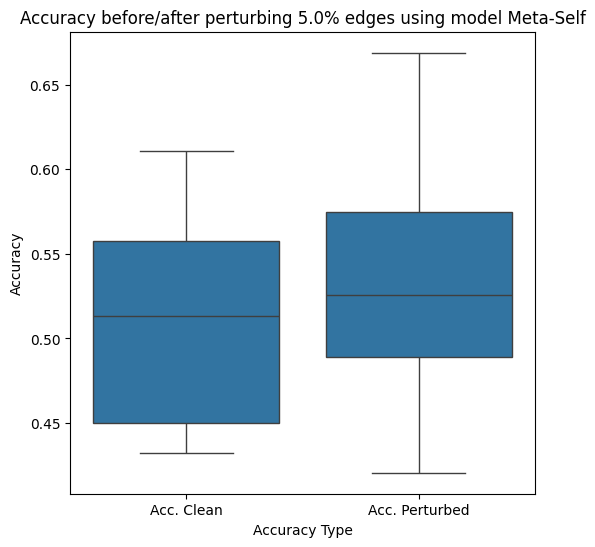

In [83]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming clean_acc and attacked_acc are lists of accuracy values
# Combine into a DataFrame
data = {
    'Accuracy Type': ['Acc. Clean'] * len(clean_acc) + ['Acc. Perturbed'] * len(attacked_acc),
    'Accuracy': clean_acc + attacked_acc
}
df = pd.DataFrame(data)

# Create the boxplot
plt.figure(figsize=(6, 6))
sns.boxplot(x='Accuracy Type', y='Accuracy', data=df)

plt.title("Accuracy before/after perturbing {}% edges using model {}".format(args.ptb_rate * 100, args.model))
plt.savefig("results_on_{}.png".format(args.dataset), dpi=600)
plt.show()
